In [85]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [86]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 24

In [87]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,265.850000,0
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,266.410000,0
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,272.404999,5668204


In [88]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
2020-02-10 09:30:00-05:00,211.520004,213.800003,210.914505,213.279999,213.279999,2938100
2020-02-10 10:30:00-05:00,213.279999,213.779999,212.199997,212.500000,212.500000,1377017
2020-02-10 11:30:00-05:00,212.490204,212.628998,211.800003,212.050003,212.050003,1034574
2020-02-10 12:30:00-05:00,212.041107,212.619995,211.850006,212.360001,212.360001,664739


<AxesSubplot:xlabel='Datetime'>

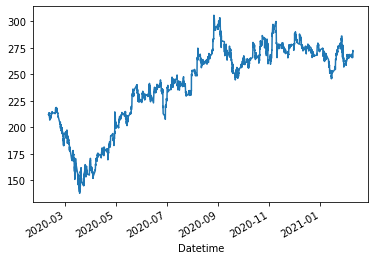

In [89]:
data['close'].plot()

In [90]:
data

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,265.850000,0
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,266.410000,0
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,272.404999,5668204


In [91]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume'], dtype='object')

In [92]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 0.35:
        return 1
    if row['close_shift'] -row['close']< -0.35:
        return -1
    else:
        return 0

In [93]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_shift
Datetime,,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0,212.360001
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0,212.500000
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0,212.619995
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0,213.100006
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0,213.060000
...,...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,265.850000,0,NaN
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,266.410000,0,NaN
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,272.404999,5668204,NaN


In [94]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,open,high,low,close,Adj Close,volume,close_shift,class_column
Datetime,,,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0,212.360001,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0,212.500000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0,212.619995,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0,213.100006,1
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0,213.060000,1
...,...,...,...,...,...,...,...,...
2021-02-09 08:00:00-05:00,265.794700,266.580000,265.610000,265.850000,265.850000,0,NaN,0
2021-02-09 09:00:00-05:00,265.950000,266.720000,265.310000,266.410000,266.410000,0,NaN,0
2021-02-09 09:30:00-05:00,266.440002,273.390015,265.750000,272.404999,272.404999,5668204,NaN,0


In [95]:
# Class divide
data['class_column'].value_counts()

 1    1957
-1    1817
 0     364
Name: class_column, dtype: int64

In [96]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [97]:
data['class_column'].value_counts()

 1    1957
-1    1817
 0     364
Name: class_column, dtype: int64

In [98]:
train_set

,open,high,low,Adj Close,volume,class_column
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,0,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,0,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,0,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,0,1
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,0,1
...,...,...,...,...,...,...
2021-02-05 15:30:00-05:00,268.179993,268.295807,267.649994,268.130005,1144618,0
2021-02-05 16:00:00-05:00,268.143300,268.450000,267.810000,267.950000,0,1
2021-02-05 17:00:00-05:00,267.840000,268.100000,266.100000,267.000000,0,1


In [99]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [100]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [101]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [102]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  DecisionTreeClassifier 1
Score:  0.16666666666666666
Calculate:  DecisionTreeClassifier 2
Score:  0.20833333333333334
Calculate:  DecisionTreeClassifier 3
Score:  0.16666666666666666
Calculate:  DecisionTreeClassifier 4
Score:  0.16666666666666666
Calculate:  DecisionTreeClassifier 5
Score:  0.25
Calculate:  DecisionTreeClassifier 6
Score:  0.25
Calculate:  DecisionTreeClassifier 7
Score:  0.2916666666666667
Calculate:  DecisionTreeClassifier 8
Score:  0.20833333333333334
Calculate:  RandomForestClassifier 1
Score:  0.16666666666666666
Calculate:  RandomForestClassifier 2
Score:  0.16666666666666666
Calculate:  RandomForestClassifier 3
Score:  0.20833333333333334
Calculate:  RandomForestClassifier 4
Score:  0.20833333333333334
Calculate:  RandomForestClassifier 5
Score:  0.16666666666666666
Calculate:  RandomForestClassifier 6
Score:  0.16666666666666666
Calculate:  RandomForestClassifier 7
Score:  0.20833333333333334
Calculate:  RandomForestClassifier 8
Score:  0.208333333

In [103]:
estimators=[
            ('GBC12', classifiers['GradientBoostingClassifier 5']),
            ('GBC11', classifiers['GradientBoostingClassifier 9']),
            ]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(x_train, y_train)
predicted = ensemble.predict(x_test)
score_ensemble = accuracy_score(y_test.values, predicted)
print('Score: ',  score_ensemble)

Score:  0.25


In [104]:
print('Score: ',  score_ensemble)

Score:  0.25


<AxesSubplot:>

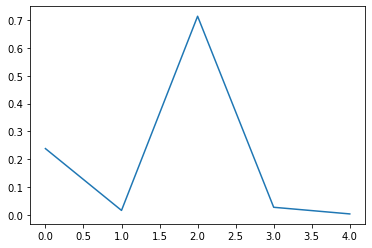

In [105]:

pd.Series(classifiers['GradientBoostingClassifier 12'].feature_importances_).plot()

In [106]:
classifiers['GradientBoostingClassifier 12'].feature_importances_

array([0.23841817, 0.01644125, 0.71355614, 0.0277079 , 0.00387655])